# DQN Atari Games


In [1]:
%matplotlib inline

import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import namedtuple
import math
import random

import torch
import torch.nn as nn

# from preprocessing.atari import preprocess_breakout
# from models.dqn import AtariDQN

### Global parameters

In [2]:
ENV_NAME = 'Breakout-v0'

N_EPISODES = 10
D = (1, 80, 80)  # Dimension of the frame after preprocessing BCHW

FIG_SIZE = (15, 8)  # Usefull for stats plotting
USE_CUDA = False
RENDER_ENV = True

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

Stats = namedtuple('Stats', ('episode_lengths', 'episode_rewards'))

device = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
space = (1, *D)
print(space)

(1, 1, 80, 80)


### Init the env

In [4]:
env = gym.make(ENV_NAME)

### Define the NNs

In [5]:
class AtariDQN(nn.Module):

    def __init__(self, input_shape, n_actions):
        """
        Deep-Q-Network (DQN) is composed of:
            - 3 convolution layers
            - 2 fully-connected linear layers
            """

        super(AtariDQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))  # Compute the output of the conv part of the network to find its final dimension
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

### Initialize the NNs

In [6]:
policy_net = AtariDQN(D, env.action_space.n).to(device)
state_value_net = AtariDQN(D, env.action_space.n).to(device)

print(policy_net)
print(state_value_net)

AtariDQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)
AtariDQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_fea

### Preprocessing for game frames

In [7]:
def preprocess_breakout(image):
    image = image[32: 192]  # Crop the not necessary part of the image
    image = image[::2, ::2, ::3]
    image[image != 0] = 1
    image = np.expand_dims(np.rollaxis(image, 2, 0), axis=0)
    return torch.from_numpy(image).type(torch.float)

### Define the game Agent

In [8]:
class BreakoutAgent:

    def __init__(self,
                 env,
                 state_shape=(1, 80, 80),
                 render_env=False,
                 epsilon_start=0.9,
                 epsilon_end=0.05,
                 epsilon_decay=200
                 ):
        self.env = env
        self.state_shape = state_shape
        self.render_env = render_env
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon = epsilon_start

    def _update_espilon(self, steps_done):
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                       math.exp(-1. * steps_done / self.epsilon_decay)

    def reset(self):
        return preprocess_breakout(self.env.reset())

    def render(self):
        if self.render_env:
            return self.env.render()
        else:
            return None

    def choose_action(self, state, policy_net, steps_done):
        # Update epsilon
        self._update_espilon(steps_done)
        sample = random.random()

        if sample < self.epsilon:
            # Perform a random action selection
            return random.randrange(self.env.action_space.n)
        else:
            # Choose an action accordingly to the policy parameterization
            # -> choose the action with the highest probability accordingly the policy
            with torch.no_grad():
                # Feed the policy network with the state -> obtain the probability for each action
                action_prob = policy_net(state)
                # t.max(1) compute the max and return a tuple (max_val, max_index)
                # We need the action (so the index)
                return action_prob.max(1)[1].item()

    def act(self, action):
        state, reward, done, info = self.env.step(action)
        return preprocess_breakout(state), reward, done, info

    def close(self):
        return self.env.close()

### Initiate the game Agent

In [9]:
agent = BreakoutAgent(env, 
                      state_shape=D,
                      render_env=RENDER_ENV,
                      epsilon_start=EPS_START, 
                      epsilon_end=EPS_END,
                      epsilon_decay=EPS_DECAY
                     )

### Training loop

In [10]:

episode_length = 0
total_reward = np.zeros(N_EPISODES)

stats = Stats(
    episode_lengths=np.zeros(N_EPISODES),
    episode_rewards=np.zeros(N_EPISODES)
)

last_state = None

for i_episode in range(N_EPISODES):
    done = False

    # Reset the env after each episode termination
    current_state = agent.reset()
    state = current_state

    while not done:
        agent.render()
        action = agent.choose_action(state=state, policy_net=policy_net, steps_done=episode_length)
        current_state, reward, done, info = agent.act(action)

        # Compute state difference between previous and current state
        state = current_state - last_state if last_state is not None else torch.zeros((1, *D))
        last_state = current_state

        total_reward[i_episode] += reward

        # print('Episode: {} | Reward: {} | Total episode reward: {} | Episodes total reward mean {} | Info: {}'
        #      .format(i_episode + 1, reward, total_reward[i_episode], total_reward.mean(), info))
        episode_length += 1

    print('Episode terminated after {} frames'.format(episode_length + 1))
    stats.episode_lengths[i_episode] = episode_length
    stats.episode_rewards[i_episode] = total_reward[i_episode]
    episode_length = 0
    last_state = None

agent.close()
print(stats)


Episode terminated after 376 frames
Episode terminated after 181 frames
Episode terminated after 183 frames
Episode terminated after 217 frames
Episode terminated after 356 frames
Episode terminated after 214 frames
Episode terminated after 175 frames
Episode terminated after 289 frames
Episode terminated after 204 frames
Episode terminated after 179 frames
Stats(episode_lengths=array([375., 180., 182., 216., 355., 213., 174., 288., 203., 178.]), episode_rewards=array([4., 0., 0., 1., 3., 1., 0., 2., 0., 0.]))


### Show stats

#### Episode length over time

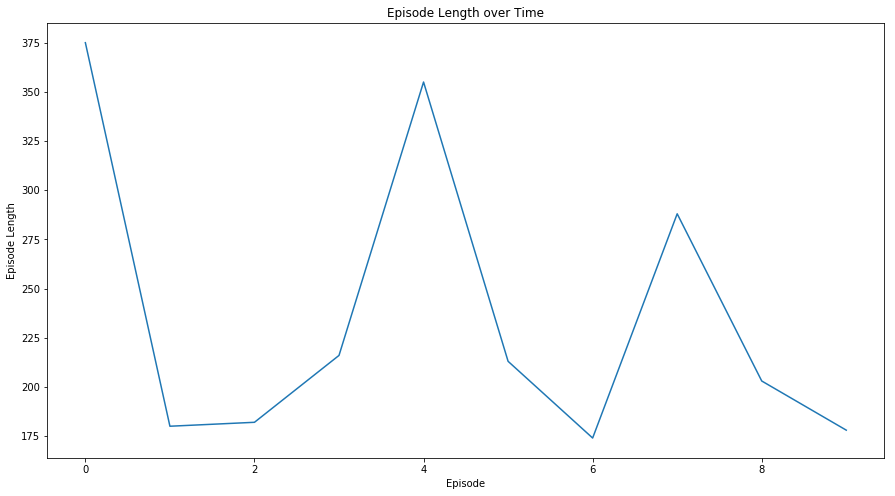

In [11]:
fig1 = plt.figure(figsize=FIG_SIZE)
plt.plot(stats.episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.show(fig1)

#### Episode reward over time

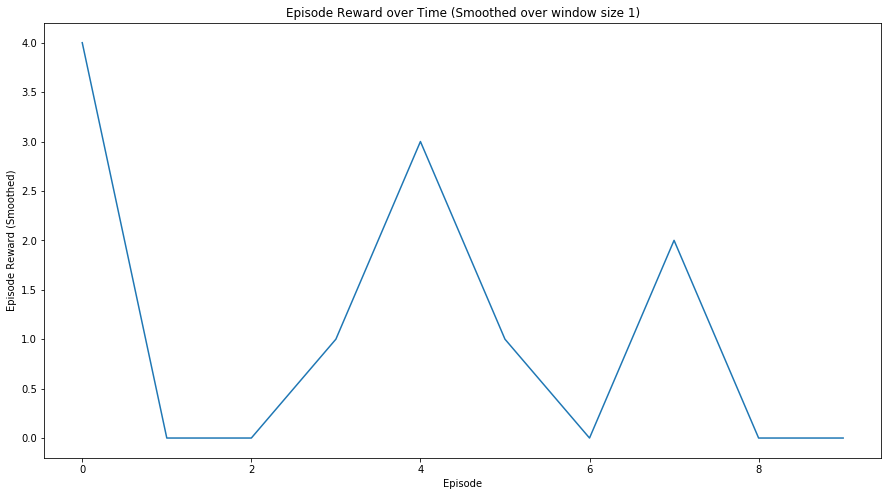

In [12]:
fig2 = plt.figure(figsize=FIG_SIZE)
smoothing_window = 1
goal_value = None
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
title = "Episode Reward over Time (Smoothed over window size {})".format(smoothing_window)

if goal_value is not None:
    plt.axhline(goal_value, color='g', linestyle='dashed')
    title = "Episode Reward over Time (Smoothed over window size" \
            " " + str(smoothing_window) + ", goal value " + str(goal_value) + ")"

plt.title(title)
plt.show(fig2)